# 独立成分分析 Independent component analysis, ICA による音源分離


### STEP1
２つの独立音源 s1, s2 を用意する。

### STEP2
s1, s2 の音量をランダムな強さ R によって加法合成した２つの合成音源 x1, x2 をつくる。これを観測音源と見立てて分離することを目指す。

### STEP3
ICA の手法に基づいて観測音源 x1, x2 に含まれている独立音源 s1, s2 を推定して音源を分離し、分離音源 sep1, sep2 をつくる。

ICA の手法としては、尖度 kurtosis 最大を探索する方法を使用する。
すなわち x1, x2 について音量バランス C を変化させながら合成音源を生成し、その音声音源の尖度が最大となる音量バランスを探索する。
尖度が最大となった時の合成音源は x1, x2 間の独立性が最も高い状態であるから、その時の音量バランスを x1, x2 に掛けあわせた音源こそが
求める分離音源 sep1, sep2 である。

尖度が信号間の独立性を評価する指標として有効な理由は参考文献 [1] および [3] が詳しい。


#### 参考

[1] 音響メディア信号処理における独立成分分析の発展と応用
http://www.slideshare.net/DaichiKitamura/history-of-independent-component-analysis-for-sound-media-signal-processing-and-its-applications

[2] EFavDB - Independent Component Analysis (ICA) demo
https://www.youtube.com/watch?v=sl7LN4EEBg8

[3] 詳解 独立成分分析―信号解析の新しい世界
https://books.google.co.jp/books?id=4NSW5v0JSBcC&lpg=PP1&pg=PA184#v=onepage&q&f=false

## 事前準備

In [1]:
import pyaudio
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
from scipy.stats import kurtosis
from IPython.display import display, Audio
%matplotlib inline

In [2]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 1024
RECORD_SECONDS = 5

In [3]:
# 録音用の関数を定義
def recording():
    audio = pyaudio.PyAudio()

    # start Recording
    stream = audio.open(format=FORMAT,
                        channels=CHANNELS,
                        rate=RATE, input=True,
                        frames_per_buffer=CHUNK)
    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    stream.stop_stream()
    stream.close()
    audio.terminate()
    return frames

## STEP1

２つの独立音源 s1, s2 を用意する。

録音するか、または録音済みの音声ファイルを読み込んで、２つの独立音源 s1, s2 の標本配列を得る。

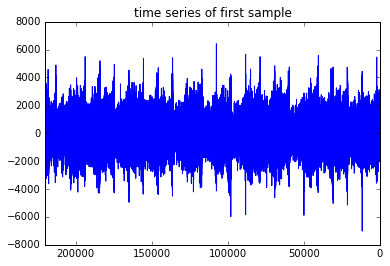

In [4]:
# record and write
# s1 = np.fromstring(b''.join(recording()), np.int16)
# wav.write('data/s1.wav', RATE, s1)

# read second sample
s1 = wav.read('data/s1.wav')[1]

plt.xlim(len(s1))
plt.title('time series of first sample')
plt.plot(s1)

display(Audio(s1, rate=RATE))

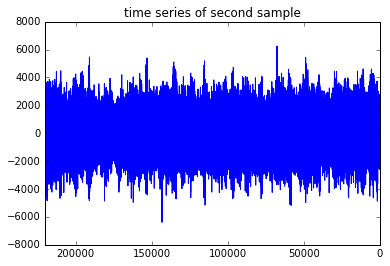

In [5]:
# record and write
# s2 = np.fromstring(b''.join(recording()), np.int16)
# wav.write('data/s2.wav', RATE, s2)

# read second sample
s2 = wav.read('data/s2.wav')[1]

plt.title('time series of second sample')
plt.xlim(len(s2))
plt.plot(s2)

display(Audio(s2, rate=RATE))

次に、s1, s2 の独立音源同士の独立性を確認するため、２つの独立音源の標本同士の散布図を描いてみる。

独立した信号同士、かつそれぞれの信号は 0 を中心とした分布 (音声なので)　なので、散布図は概ね左右上下対称となることが想定される。

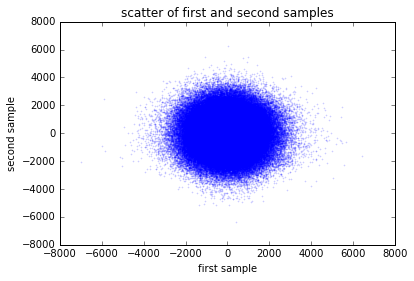

In [6]:
plt.scatter(s1, s2, s=1, marker='x', alpha=0.2)
plt.title('scatter of first and second samples')
plt.xlabel('first sample')
plt.ylabel('second sample')

## STEP2

s1, s2 の音量をランダムな強さ R によって加法合成した２つの合成音源 x1, x2 をつくる。

合成する各音源の音量倍率 R:
[[ 0.34  0.63]
 [ 0.88  0.61]]


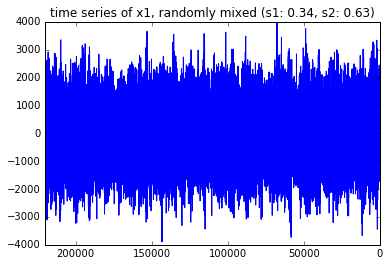

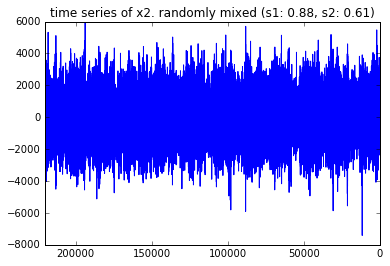

In [7]:
# Randomly mix
R = np.random.rand(4).reshape(2, 2)

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
print('合成する各音源の音量倍率 R:\n{}'.format(R))

x1, x2 = np.dot(R, (s1, s2))

plt.figure()
plt.xlim(len(x1))
plt.title('time series of x1, randomly mixed (s1: {0:.2f}, s2: {1:.2f})'.format(R[0,0], R[0,1]))
plt.plot(x1)

display(Audio(x1, rate=RATE))

plt.figure()
plt.title('time series of x2. randomly mixed (s1: {0:.2f}, s2: {1:.2f})'.format(R[1,0], R[1,1]))
plt.xlim(len(x2))
plt.plot(x2)

display(Audio(x2, rate=RATE))

ここでも、合成音源 x1, x2 の散布図を描いてみる。

s1, s2 とは異なり、x1, x2 いずれも元は同一の音源の合成からなる音源なので、相関があるのは明らか。
よって散布図は上下左右対称にならず、右上に傾いたものとなる (R の値の具合によっては、概形が細くなったり膨らんだりする)。

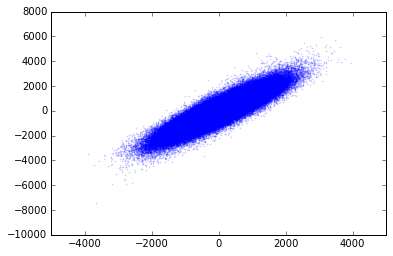

In [8]:
plt.scatter(x1, x2, s=1, marker='x', alpha=0.2)

## STEP3

ICA の手法に基づいて x1, x2 から独立音源 s1, s2 を推定して音源を分離し、分離音源 sep1, sep2 をつくる。

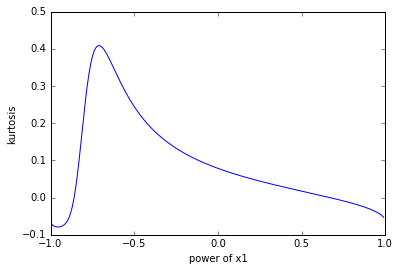

In [13]:
# 音量レベル　[-1, 1] の区間における尖度 kurtosis 分布を計算する
def kurtosis_of_mixture(p, x1, x2):
    sample1 = x1[::10]
    sample2 = x2[::10]
    p2 = np.sqrt(1 - p ** 2)
    mixed_series = p * sample1 + p2 * sample2
    m2 = np.std(mixed_series) ** 2
    m4 = np.mean([x ** 4 for x in mixed_series])
    return m4 / (m2 ** 2) - 3  # fix to Fisher's definition with -3

p_array = np.arange(-1,1,0.01)
k_array = [kurtosis_of_mixture(item, x1, x2) for item in p_array]

plt.plot(p_array, k_array)
plt.title('kurtosis of remixed x1 and x2')
plt.xlabel('power of x1')
plt.ylabel('kurtosis')

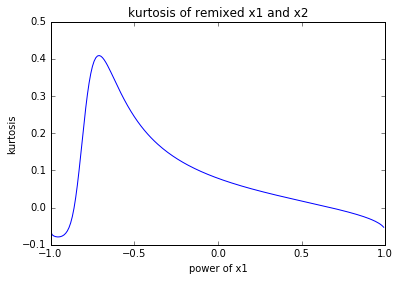

In [14]:
# SciPy 版
# [-1, 1] の区間における尖度 kurtosis を計算する
def kurtosis_of_mixture(p, x1, x2):
    sample1 = x1[::10]
    sample2 = x2[::10]
    p2 = np.sqrt(1 - p ** 2)
    mixed_series = p * sample1 + p2 * sample2
    return kurtosis(mixed_series)

p_array = np.arange(-1,1,0.01)
k_array = [kurtosis_of_mixture(item, x1, x2) for item in p_array]

plt.plot(p_array, k_array)
plt.title('kurtosis of remixed x1 and x2')
plt.xlabel('power of x1')
plt.ylabel('kurtosis')

In [11]:
# 尖度の最大・最小値を用いて、合成音源 x1, x2 の独立性が最大となるように行列変換する
k_max = max(k_array)
k_argmax = p_array[k_array.index(k_max)]
k_min = min(k_array)
k_argmin = p_array[k_array.index(k_min)]

print('''max(k): {:.2f}, argmax(k): {:.2f},
min(k): {:.2f}, argmin(k): {:.2f}'''.format(
        k_max, k_argmax,
        k_min, k_argmin))

c = np.array((
            (k_argmax, np.sqrt(1 - k_argmax ** 2)), 
            (k_argmin, np.sqrt(1 - k_argmin ** 2))
        ))

sep1, sep2 = np.dot(c, np.array((x1, x2)))

print('分離音源 sep1')
display(Audio(sep1, rate=RATE))
print('分離音源 sep2')
display(Audio(sep2, rate=RATE))

max(k): 0.41, argmax(k): -0.71,
min(k): -0.08, argmin(k): -0.96
分離音源 sep1


分離音源 sep2


分離音源 sep1, sep2 の散布図を描いてみる。

x1, x2 の散布図のように、明らかな相関のある散布図に比べ、s1, s2 の散布図のような上下左右対称に近い散布図に近づいていることが想定される。

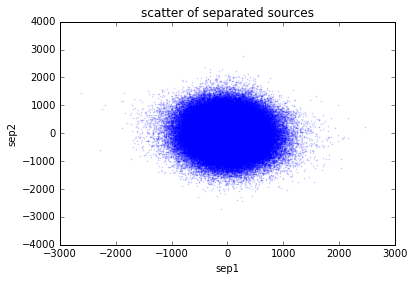

In [12]:
plt.title('scatter of separated sources')
plt.scatter(sep1, sep2, s=1, marker='x', alpha=0.2)
plt.xlabel('sep1')
plt.ylabel('sep2')

## 課題

### 精度

尖度の最大・最小値を用いて2つの信号の独立性を高める計算は参考 [2] の実装を参考にした。

観測信号 x1, x2 を合成し尖度が最大となる音量バランスを探索する箇所では、離散値で計算している。
よって合成する乱数によってたまたま相関が極めて強く出てしまった場合には、分離精度は不十分になる。
尖度 k は音量レベル p の関数 k(p) と表せるので、これの微分操作で極大値を求められるとスマートかもしれない。

参考 [1] にあるような、白色化行列および回転行列による変換であれば理解しやすく、精度も調整しやすそう。そちらも試してみたい。


### 運用上の懸念

計算量的に、リアルタイム処理が可能かどうかは未検討。
